In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARIMA
import warnings
import time
import math
from sklearn import preprocessing

D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
warnings.filterwarnings('ignore')
matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams['backend'] = 'SVG'

In [3]:
data_path = 'E:/论文/论文2/数据/'
fig_path = 'E:/论文/论文2/论文图片/'
df=pd.read_excel(data_path+'预计涨幅_改.xlsx',index_col=0).iloc[64:,:]
df.reset_index(inplace=True)

In [4]:
df['黄金价格差分'] = df['USD (PM)'][1:].diff(1) # 后一项减前一项
df['比特币价格差分'] = df['Value'].diff(1)
df['黄金价格差分'].fillna(0, inplace=True)
df['比特币价格差分'].fillna(0, inplace=True)

In [5]:
df

,Date,USD (PM),Value,DealDay,黄金涨幅(%),比特币涨幅(%),黄金5日均价,黄金5日乖离率,比特币5日均价,比特币5日乖离率,...,黄金购买风险,比特币购买风险,黄金价格残差,比特币价格残差,预计黄金价格,预计比特币价格,预计黄金涨幅,预计比特币涨幅,黄金价格差分,比特币价格差分
0,2016-11-14,1213.60,706.46,1,0.315545,0.651326,0.606387,0.264584,0.011401,0.542606,...,0.145714,0.988496,1216,0,1222.0,0,-0.011687,NaN,0.00,0.00
1,2016-11-15,1226.95,710.91,1,0.599125,0.651894,0.602415,0.436208,0.011367,0.557581,...,0.149779,0.988873,1212,0,1208.0,0,-0.004614,NaN,0.00,4.45
2,2016-11-16,1229.20,711.73,1,0.510951,0.643460,0.601704,0.466028,0.011355,0.561163,...,0.146144,0.988963,1205,0,1231.0,0,0.003301,NaN,2.25,0.82
3,2016-11-17,1226.75,736.96,1,0.474138,0.699675,0.600754,0.461916,0.011462,0.603138,...,0.140667,0.990018,1209,0,1228.0,0,-0.000976,NaN,-2.45,25.23
4,2016-11-18,1211.00,747.52,1,0.369812,0.665057,0.598261,0.375430,0.011607,0.605859,...,0.130717,0.990087,1208,0,1220.0,0,-0.005502,NaN,-15.75,10.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,2021-09-06,1821.60,51769.06,1,0.482234,0.701352,0.891906,0.463616,0.802853,0.607951,...,0.477009,0.535210,0,45230,1812.0,49439,-0.006416,-0.010178,-2.10,1821.68
1758,2021-09-07,1802.15,52677.40,1,0.390603,0.670330,0.890888,0.368978,0.815106,0.611716,...,0.477124,0.519057,0,48689,1812.0,52036,-0.005270,0.005156,-19.45,908.34
1759,2021-09-08,1786.00,46809.17,1,0.407108,0.458969,0.887195,0.321490,0.807012,0.439799,...,0.479799,0.498486,0,51410,1812.0,52847,0.005466,0.003220,-16.15,-5868.23
1760,2021-09-09,1788.25,46078.38,1,0.505429,0.615979,0.883722,0.372245,0.794302,0.440009,...,0.487809,0.482244,0,48109,1812.0,47005,0.014558,0.004184,2.25,-730.79


前面计算时涨幅被归一化了，重新计算

In [6]:
tmp1_gold = df['USD (PM)'].copy() # 前一天的价格
tmp2_gold = df['USD (PM)'].copy() # 当天的价格
tmp1_gold.index = tmp1_gold.index + 1
df['黄金涨幅(%)'] = 100*(tmp2_gold-tmp1_gold)/tmp1_gold

tmp1_bitcoin = df['Value'].copy() # 前一天的价格
tmp2_bitcoin = df['Value'].copy() # 当天的价格
tmp1_bitcoin.index = tmp1_bitcoin.index + 1
df['比特币涨幅(%)'] = 100*(tmp2_bitcoin-tmp1_bitcoin)/tmp1_bitcoin

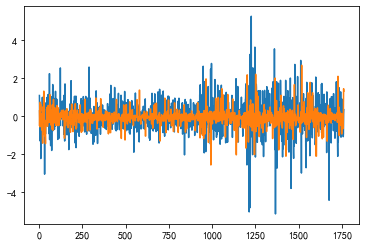

In [7]:
df['黄金涨幅(%)'].plot() 
(100*df['预计黄金涨幅'][1:]).plot()
#plt.savefig('预计黄金涨幅.png')
plt.show()

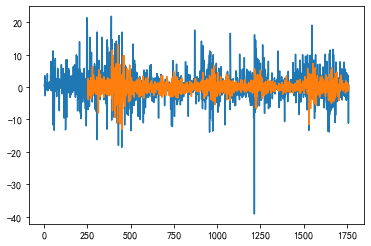

In [8]:
df['比特币涨幅(%)'].plot()
(100*df['预计比特币涨幅']).plot()
#plt.savefig('预计比特币涨幅.png')
plt.show()

出现离群值，将其改为前一天的涨幅

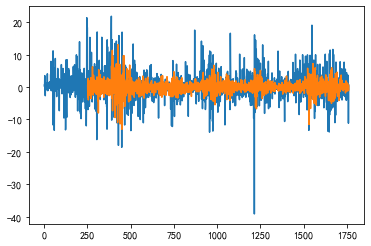

In [9]:
df['预计比特币涨幅'][1636] = df['预计比特币涨幅'][1635]

df['比特币涨幅(%)'].plot()
(100*df['预计比特币涨幅']).plot()
#plt.savefig('预计比特币涨幅.png')
plt.show()

In [10]:
df.head()

,Date,USD (PM),Value,DealDay,黄金涨幅(%),比特币涨幅(%),黄金5日均价,黄金5日乖离率,比特币5日均价,比特币5日乖离率,...,黄金购买风险,比特币购买风险,黄金价格残差,比特币价格残差,预计黄金价格,预计比特币价格,预计黄金涨幅,预计比特币涨幅,黄金价格差分,比特币价格差分
0,2016-11-14,1213.60,706.46,1,NaN,NaN,0.606387,0.264584,0.011401,0.542606,...,0.145714,0.988496,1216,0,1222.0,0,-0.011687,NaN,0.00,0.00
1,2016-11-15,1226.95,710.91,1,1.100033,0.629901,0.602415,0.436208,0.011367,0.557581,...,0.149779,0.988873,1212,0,1208.0,0,-0.004614,NaN,0.00,4.45
2,2016-11-16,1229.20,711.73,1,0.183382,0.115345,0.601704,0.466028,0.011355,0.561163,...,0.146144,0.988963,1205,0,1231.0,0,0.003301,NaN,2.25,0.82
3,2016-11-17,1226.75,736.96,1,-0.199317,3.544884,0.600754,0.461916,0.011462,0.603138,...,0.140667,0.990018,1209,0,1228.0,0,-0.000976,NaN,-2.45,25.23
4,2016-11-18,1211.00,747.52,1,-1.283880,1.432914,0.598261,0.375430,0.011607,0.605859,...,0.130717,0.990087,1208,0,1220.0,0,-0.005502,NaN,-15.75,10.56


处理残差中的空值（主要来自非交易日），使用上一次交易日的残差进行补充  
对残差，预计涨幅进行归一化

In [11]:
df['黄金价格残差'] = df['黄金价格残差'].replace(0,np.nan).fillna(method='ffill').replace(np.nan,0)
df['预计黄金涨幅'] = df['预计黄金涨幅'].replace(0,np.nan).fillna(method='ffill').replace(np.nan,0)

# 处理离群值
df['比特币价格残差归一化'] = 0
Q1 = df['比特币价格残差'].quantile(0.25)
Q3 = df['比特币价格残差'].quantile(0.75)
IQR = Q3 - Q1
tmp_df = df[(df['比特币价格残差'] >= (Q1 - 1.5 * IQR)) & (df['比特币价格残差'] <= (Q3 + 1.5 * IQR))]['比特币价格残差'].copy()
max_,min_= tmp_df.max(), tmp_df.min()
df['比特币价格残差归一化'] = tmp_df.apply(lambda x:(x-min_)/(max_-min_))
for i in range(len(df['比特币价格残差'])):
    if (df['比特币价格残差'][i] < (Q1 - 1.5 * IQR)) & (df['比特币价格残差'][i] > 1):
        df['比特币价格残差归一化'][i] = 0
    if df['比特币价格残差'][i] > (Q3 + 1.5 * IQR):
        df['比特币价格残差归一化'][i] = 1

df['预计比特币涨幅归一化'] = 0
Q1 = df['预计比特币涨幅'].quantile(0.25)
Q3 = df['预计比特币涨幅'].quantile(0.75)
IQR = Q3 - Q1
tmp_df = df[(df['预计比特币涨幅'] >= (Q1 - 1.5 * IQR)) & (df['预计比特币涨幅'] <= (Q3 + 1.5 * IQR))]['预计比特币涨幅'].copy()
max_,min_= tmp_df.max(), tmp_df.min()
df['预计比特币涨幅归一化'] = tmp_df.apply(lambda x:(x-min_)/(max_-min_)) # 负向指标归一化
for i in range(len(df['预计比特币涨幅'])):
    if df['预计比特币涨幅'][i] < (Q1 - 1.5 * IQR):
        df['预计比特币涨幅归一化'][i] = 1
    if df['预计比特币涨幅'][i] > (Q3 + 1.5 * IQR):
        df['预计比特币涨幅归一化'][i] = 0

# 风险指标正向化
max_ =df['黄金购买风险'].max()
df['黄金购买风险正向化'] = df['黄金购买风险'].apply(lambda x:max_-x)
max_ =df['比特币购买风险'].max()
df['比特币购买风险正向化'] = df['比特币购买风险'].apply(lambda x:max_-x)

In [12]:
"""values = df[['黄金价格残差','预计黄金涨幅','比特币价格残差','预计比特币涨幅']].values #dataframe转换为array
values = values.astype('float32') #定义数据类型
data = preprocessing.scale(values) 
tmp_df = pd.DataFrame(data) #将array还原为dataframe
tmp_df.columns = ['黄金价格残差归一化','预计黄金涨幅归一化','比特币价格残差归一化','预计比特币涨幅归一化'] #命名标题行
df = pd.concat([df,tmp_df],axis=1)"""

"values = df[['黄金价格残差','预计黄金涨幅','比特币价格残差','预计比特币涨幅']].values #dataframe转换为array\nvalues = values.astype('float32') #定义数据类型\ndata = preprocessing.scale(values) \ntmp_df = pd.DataFrame(data) #将array还原为dataframe\ntmp_df.columns = ['黄金价格残差归一化','预计黄金涨幅归一化','比特币价格残差归一化','预计比特币涨幅归一化'] #命名标题行\ndf = pd.concat([df,tmp_df],axis=1)"

In [14]:
max_,min_=df['黄金价格残差'].max(),df['黄金价格残差'].min()
df['黄金价格残差归一化'] = df['黄金价格残差'].apply(lambda x:(max_-x)/(max_-min_))
max_,min_=df['预计黄金涨幅'].max(),df['预计黄金涨幅'].min()
df['预计黄金涨幅归一化'] = df['预计黄金涨幅'].apply(lambda x:(max_-x)/(max_-min_))

In [15]:
df[['黄金价格残差归一化','预计黄金涨幅归一化','黄金牛市','黄金购买风险正向化','比特币价格残差归一化','预计比特币涨幅归一化','比特币牛市','比特币购买风险正向化']].describe()

,黄金价格残差归一化,预计黄金涨幅归一化,黄金牛市,黄金购买风险正向化,比特币价格残差归一化,预计比特币涨幅归一化,比特币牛市,比特币购买风险正向化
count,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000,1511.000000,1762.000000,1762.000000
mean,0.494047,0.523662,0.528125,0.460450,0.433185,0.502006,0.533059,0.466297
std,0.322458,0.092470,0.336099,0.318729,0.304830,0.215120,0.390598,0.381440
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.205811,0.492804,0.258333,0.155257,0.243176,0.376764,0.133333,0.041516
50%,0.340194,0.521810,0.522222,0.463072,0.390201,0.506029,0.566667,0.433914
75%,0.854722,0.552496,0.844444,0.714445,0.548049,0.629915,0.966667,0.858507
max,1.000000,1.000000,1.000000,0.976052,1.000000,1.000000,1.000000,0.992740


计算买入评分  
买入评分=涨幅X10+牛市X5-残差+1/购买风险

In [16]:
# 定义熵权法函数
# 输入：已经归一化的数据
def cal_weight(x):
    #x = x.apply(lambda x: ((x - np.min(x)) / (np.max(x) - np.min(x))))
    rows = x.index.size 
    cols = x.columns.size 
    k = 1.0 / math.log(rows)
    lnf = [[None] * cols for i in range(rows)]
    x = np.array(x)
    lnf = [[None] * cols for i in range(rows)]
    lnf = np.array(lnf)
    for i in range(0, rows):
        for j in range(0, cols):
            if x[i][j] == 0:
                lnfij = 0.0
            else:
                p = x[i][j] / x.sum(axis=0)[j]
                lnfij = math.log(p) * p * (-k)
            lnf[i][j] = lnfij
    lnf = pd.DataFrame(lnf)
    E = lnf

    d = 1 - E.sum(axis=0)
    w = [[None] * 1 for i in range(cols)]
    for j in range(0, cols):
        wj = d[j] / sum(d)
        w[j] = wj
    #w = pd.DataFrame(w)
    return w

In [17]:
#w1 = cal_weight(df[['预计黄金价格归一化','预计黄金涨幅归一化','黄金牛市','黄金购买风险正向化']])
w1 = cal_weight(df[['黄金价格残差归一化','预计黄金涨幅归一化','黄金牛市','黄金购买风险正向化']])
w2 = cal_weight(df[['比特币价格残差归一化','预计比特币涨幅归一化','比特币牛市','比特币购买风险正向化']])
print(w1)
print(w2)

[0.2842838649670091, 0.021401183834291952, 0.3351381903594644, 0.35917676083923455]
[0.03398845514840247, 0.875600509413795, 0.04179892546867705, 0.048612109969125385]


In [18]:
df['黄金买入评分'] = w1[0]*df['黄金价格残差归一化'] + w1[1]*df['预计黄金涨幅归一化'] + w1[2]*df['黄金牛市'] + w1[3]*df['黄金购买风险正向化']
df['比特币买入评分'] = w2[0]*df['比特币价格残差归一化'] + w2[1]*df['预计比特币涨幅归一化'] + w2[2]*df['比特币牛市'] + w2[3]*df['比特币购买风险正向化']

对比评分合理性

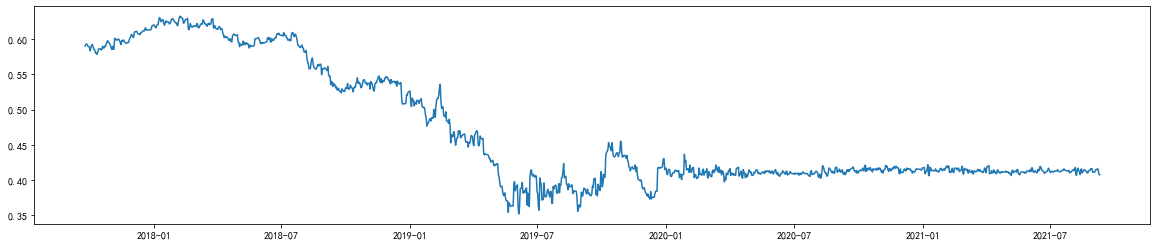

In [19]:
plt.figure(figsize=(20,4))
plt.plot(df['Date'][315:],df['黄金买入评分'][315:])
#plt.savefig('黄金买入评分.png')
plt.show()

上下两个图对比着看，同一时间段，下图下降，上图在上升即为合理。  
低谷时买入，峰值时卖出

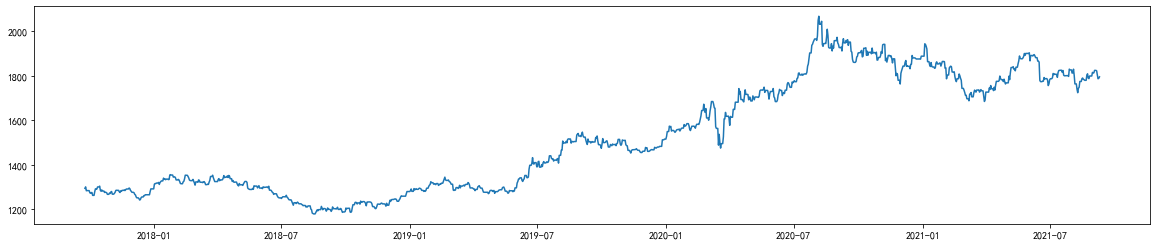

In [20]:
plt.figure(figsize=(20,4))
plt.plot(df['Date'][315:],df['USD (PM)'][315:])
plt.show()

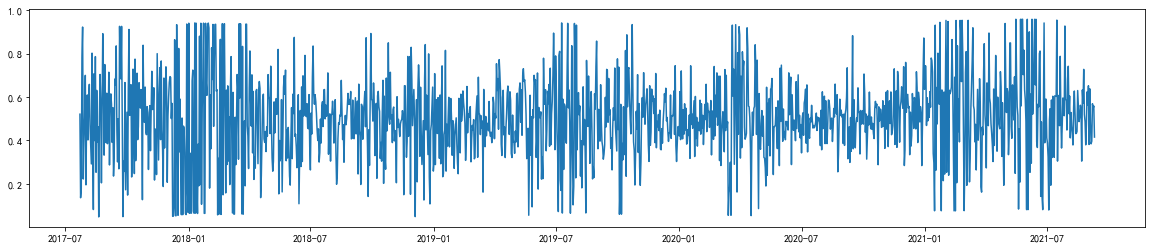

In [21]:
plt.figure(figsize=(20,4))
plt.plot(df['Date'],df['比特币买入评分'])
#plt.savefig('比特币买入评分.png')
plt.show()

某一个值太大，归一化时影响其他的结果，所以去除最大值，归一化后重新将该值设为1

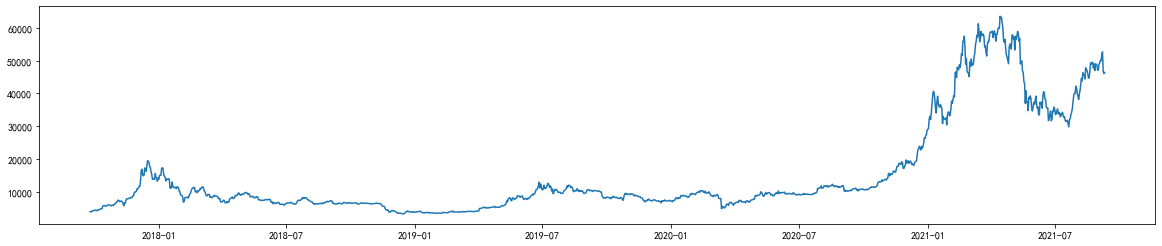

In [22]:
plt.figure(figsize=(20,4))
plt.plot(df['Date'][315:],df['Value'][315:])
plt.show()

买入评分归一化

In [23]:
max_,min_=df['黄金买入评分'].max(),df['黄金买入评分'].min()
df['黄金买入评分']=df['黄金买入评分'].apply(lambda x:(x-min_)/(max_-min_))
max_,min_=df['比特币买入评分'].max(),df['黄金买入评分'].min()
df['比特币买入评分']=df['比特币买入评分'].apply(lambda x:(x-min_)/(max_-min_))

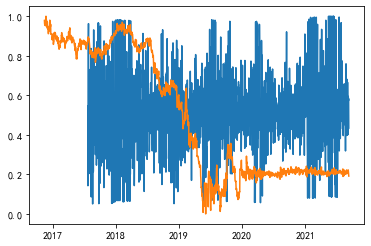

In [24]:
plt.plot(df['Date'],df['比特币买入评分'])
plt.plot(df['Date'],df['黄金买入评分'])
#plt.savefig('买入评分图.png')
plt.show()

初始化值，将数据类型设置为浮点型，整型会直接对结果取整，导致小数位的丢失

In [25]:
df['总资产'][0]=1000.0
df['现金持有份额'][0]=1000.0
df['黄金持有份额'][0]=0.0
for i in df.columns[1:]:
    df[i]=df[i].astype('float')

开始买入与卖出：
1. 黄金评分大于0.55买入，小于0.45时卖出，比特币评分大于0.8时买入，小于0.6时卖出，即黄金买入标准0.55，卖出标准0.45
2. 买卖规则  
    判断是否为黄金交易日，是考虑黄金，不是不考虑黄金  
    当比特币和黄金可同时买入时，若黄金买入评分-0.55>(比特币买入评分-0.8)X2   (黄金评分买入标准比比特币低，上升空间更大)  
    买入额度=当前现金额度X买入评分X（1-手续费）/当前价格  
    卖出额度=持有份额*（1-评分+卖出标准）    
 
计算现金时应注意手续费

In [26]:
# df: 整张表
# start: 开始交易的交易日（在表中的index）
# end: 结束交易的交易日（在表中的index）
# per_gold, per_bt: 黄金和比特币的佣金
# [lb_gold,ub_gold]: 黄金的投资意愿区间
# [lb_bt,ub_bt]: 比特币的投资意愿区间
def trade(df,start,end,per_gold,per_bt,ub_gold,lb_gold,ub_bt,lb_bt):
    for i in range(start,np.min([end, df.shape[0]])):
        bt = df['比特币买入评分'][i]
        gold = df['黄金买入评分'][i]
        df['当前黄金利润'][i]=df['当前黄金利润'][i-1]+df['黄金价格差分'][i-1]*df['黄金持有份额'][i-1]
        df['当前比特币利润'][i]=df['当前比特币利润'][i-1]+df['比特币价格差分'][i-1]*df['比特币持有份额'][i-1]
        df['黄金持有份额'][i]=df['黄金持有份额'][i-1]
        df['现金持有份额'][i]=df['现金持有份额'][i-1]
        df['比特币持有份额'][i]=df['比特币持有份额'][i-1]
        if df['DealDay'][i]:  # 判断交易日
            if gold > ub_gold:
                if bt > ub_bt:# 两者都可买入时
                    if gold-ub_gold>(bt-ub_bt)*2:  # 买入黄金
                        df['黄金持有份额'][i]=df['黄金持有份额'][i-1]+df['现金持有份额'][i-1]*gold*(1-per_gold)/df['USD (PM)'][i-1]
                        df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*gold
                        #print('两者选黄金',df['黄金持有份额'][i],df['现金持有份额'][i],df['现金持有份额'][i-1],gold,1-per_gold,df['USD (PM)'][i-1])
                    else:  # 买入比特币
                        df['比特币持有份额'][i]=df['比特币持有份额'][i-1]+df['现金持有份额'][i-1]*bt*(1-per_bt)/df['Value'][i-1]
                        df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*bt
                        #print('两者选比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
                else: # 只能买黄金时
                    df['黄金持有份额'][i]=df['黄金持有份额'][i-1]+df['现金持有份额'][i-1]*gold*(1-per_gold)/df['USD (PM)'][i-1]
                    df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*gold
                    #print('只能买黄金',df['黄金持有份额'][i])
            if gold<lb_gold:  # 卖出黄金
                df['黄金持有份额'][i]=df['黄金持有份额'][i-1]-df['黄金持有份额'][i-1]*(1+gold-ub_gold)
                df['现金持有份额'][i]=df['现金持有份额'][i-1]+df['黄金持有份额'][i-1]*(1+gold-ub_gold)*(1-per_gold)*df['USD (PM)'][i-1]
                #print('卖黄金',df['黄金持有份额'][i],df['现金持有份额'][i])
            continue    
        if bt > ub_bt:  # 买入比特币
            df['比特币持有份额'][i]=df['比特币持有份额'][i-1]+df['现金持有份额'][i-1]*bt*2*(1-per_bt)/df['Value'][i-1]
            df['现金持有份额'][i]=df['现金持有份额'][i-1]-df['现金持有份额'][i-1]*bt
            #print('买比特币',df['比特币持有份额'][i],df['现金持有份额'][i])
        if bt < lb_bt:  # 卖出比特币
            df['比特币持有份额'][i]=df['比特币持有份额'][i-1]-df['比特币持有份额'][i-1]*(1+gold-lb_bt)
            df['现金持有份额'][i]=df['现金持有份额'][i-1]+df['比特币持有份额'][i-1]*(1+gold-lb_bt)*(1-per_gold)*df['Value'][i-1]
            #print('卖比特币',df['比特币持有份额'][i],df['现金持有份额'][i])

0.5240555831452944
0.4913434706554717 



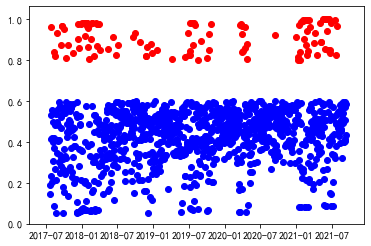

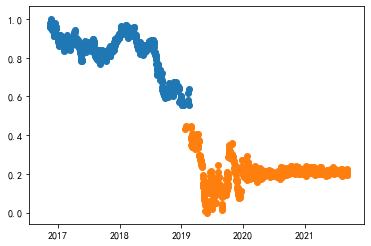

In [27]:
per_gold = 0.01
per_bt = 0.02
df['当前黄金利润'] = 0
df['当前比特币利润'] = 0

start = 1
end = df.shape[0]
print(df['比特币买入评分'][start:end].mean())
print(df['黄金买入评分'][start:end].mean(),'\n')

# 投资意愿区间
ub_gold = 0.55 # 黄金买0.55，卖0.45,中间不动
lb_gold = 0.45 
ub_bt = 0.8   # 比特币买0.8，卖0.6
lb_bt = 0.6
trade(df,start,end,per_gold,per_bt,ub_gold,lb_gold,ub_bt,lb_bt)
plt.scatter(df['Date'][df['比特币买入评分']>ub_bt][start:end],df['比特币买入评分'][df['比特币买入评分']>ub_bt][start:end],label='买入',c='r')
plt.scatter(df['Date'][df['比特币买入评分']<lb_bt][start:end],df['比特币买入评分'][df['比特币买入评分']<lb_bt][start:end],label='卖出',c='b')
plt.show()

plt.scatter(df['Date'][df['黄金买入评分']>ub_gold],df['黄金买入评分'][df['黄金买入评分']>ub_gold])
plt.scatter(df['Date'][df['黄金买入评分']<lb_gold],df['黄金买入评分'][df['黄金买入评分']<lb_gold])
#plt.savefig('黄金评分对比图.png')
plt.show()

计算总资产

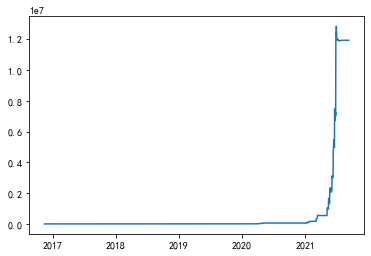

In [28]:
df['总资产']=df['黄金持有份额']*df['USD (PM)']+df['比特币持有份额']*df['Value']+df['现金持有份额']
plt.plot(df['Date'],df['总资产'])
plt.savefig(fig_path+'图6总资产走势图.svg',format='svg')
plt.show()

In [29]:
print('最终持有的资产总额:',df['总资产'][-1:])

最终持有的资产总额: 1761    1.192189e+07
Name: 总资产, dtype: float64


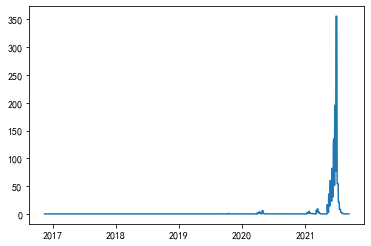

In [30]:
plt.plot(df['Date'],df['比特币持有份额'])
#plt.savefig('比特币持有份额走势图.png')
plt.show()

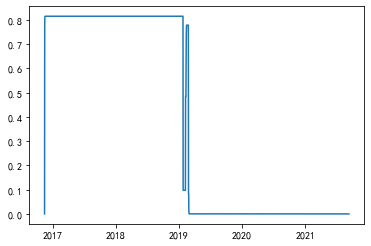

In [31]:
plt.plot(df['Date'],df['黄金持有份额'])
#plt.savefig('黄金持有份额走势图.png')
plt.show()

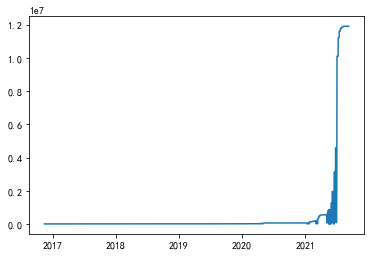

In [32]:
plt.plot(df['Date'],df['现金持有份额'])
#plt.savefig('现金持有份额额走势图.png')
plt.show()

In [33]:
df.to_excel(data_path+'所有数据.xlsx',index=False)